# Model

In [10]:
import torch_struct
import torch
import matplotlib.pyplot as plt

## Linear Chain

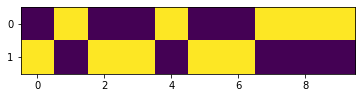

In [33]:
batch, N, C = 3, 10, 2
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = torch_struct.LinearChainCRF(log_potentials)
show_chain(dist.argmax[0])

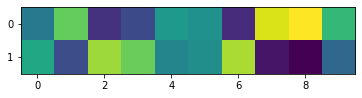

In [35]:
show_chain(dist.marginals[0])

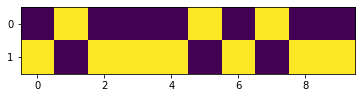

In [41]:
event = dist.to_event(torch.tensor([[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]]), 2)
show_chain(event[0])

## HMM

## Semi-Markov

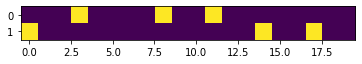

In [64]:
batch, N, C, K = 3, 20, 2, 6
def show_sm(chain):
    plt.imshow(chain.detach().sum(1).sum(-1).transpose(0, 1))

# batch, N, K, z_n, z_n_1
log_potentials = torch.rand(batch, N, K, C, C)
log_potentials[:, :, :3] = -1e9
dist = torch_struct.SemiMarkovCRF(log_potentials)
show_sm(dist.argmax[0])

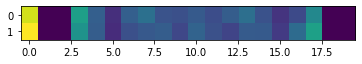

In [65]:
show_sm(dist.marginals[0])

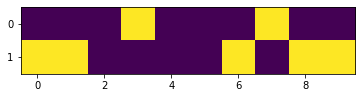

In [71]:
# Use -1 for segments.
event = dist.to_event(torch.tensor([[0, 1, -1, 1, -1, -1, 0, 1, 0, 1, 1]]), (2, 6))
show_sm(event[0])

## Alignment

## Dependency Trees

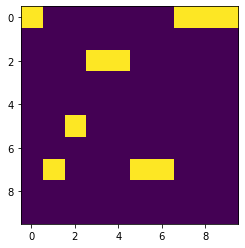

In [76]:
batch, N, N = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, N)
dist = torch_struct.DependencyCRF(log_potentials)
show_deps(dist.argmax[0])

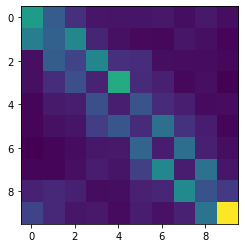

In [49]:
show_deps(dist.marginals[0])

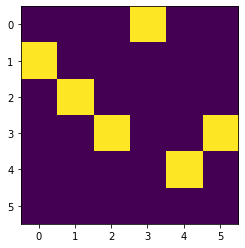

In [89]:
# Convert from 1-index standard format. (Head is 0)
event = dist.to_event(torch.tensor([[2, 3, 4, 1, 0, 4]]), None)
show_deps(event[0])

## Non-Projective Dependency Trees

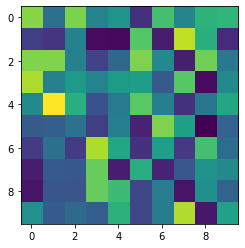

In [47]:
batch, N, N = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, N)
dist = torch_struct.NonProjectiveDependencyCRF(log_potentials)
show_deps(dist.marginals[0])

## Binary Labeled Trees

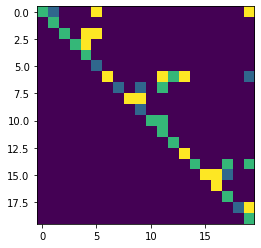

In [105]:
batch, N, NT = 3, 20, 3
def show_tree(tree):
    t = tree.detach()
    plt.imshow(t[ :, : , 0] + 
               2 * t[ :,:, 1] +
               3 * t[ :,:, 2])

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, N, NT)
dist = torch_struct.TreeCRF(log_potentials)
show_tree(dist.argmax[0])

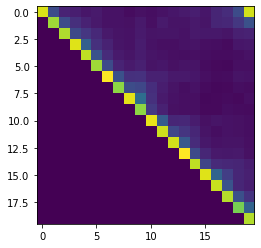

In [106]:
show_tree(dist.marginals[0])

## Probabilistic Context-Free Grammars

## Base Class